# Import modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Self-Attention vs Masked Self-Attention

- The main difference between this mechanisms is that in self attention we calculate the similarity of one input token with itself and each other token.</br>
For example: (image is from the online course "Attention in Transformers" taught by Josh Starmer)</br></br> 
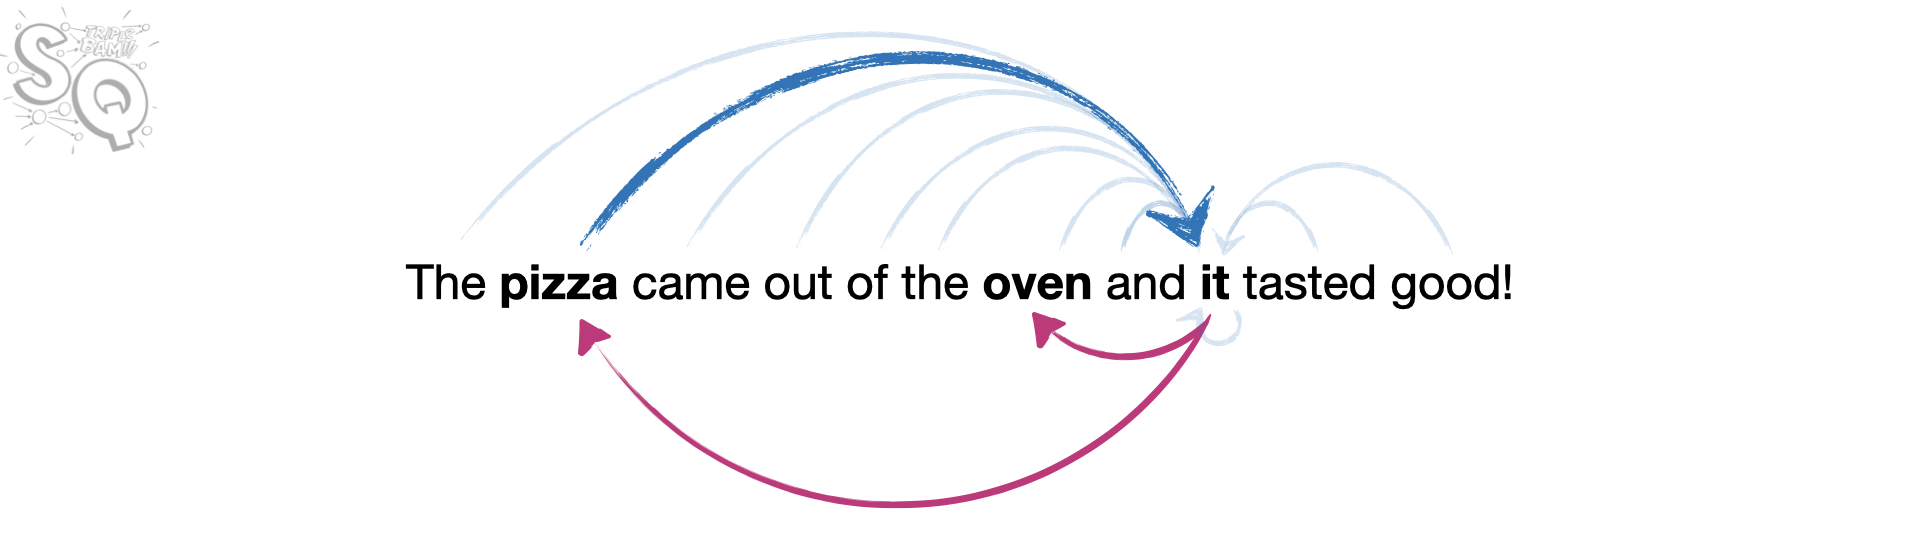
</br>

- When we use masked self attention we want to calculate the similarity of the current token and each PREVIUOS token, so for example if we are at the first token at the begining we will calculate the similarity only for this token and we dont care about the next tokens in the sequence at that moment.</br>

- For example: (image is from the online course "Attention in Transformers" taught by Josh Starmer)</br></br>
 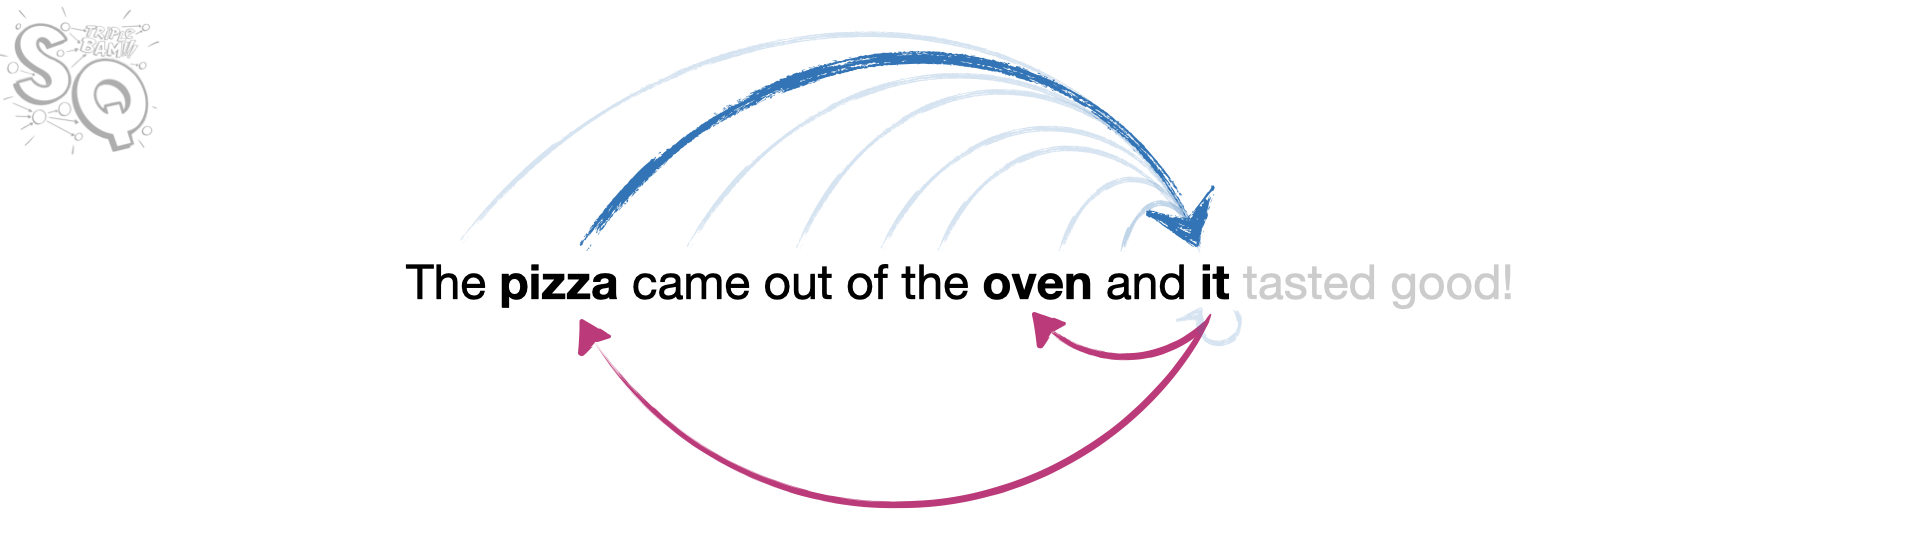

 </br>
 </br>

- Self-Attention -> Encoder-Only Transformer (contextual aware embeddings)
- Masked Self-Attention -> Decoder-Only Transformer (predict next word in the sequence / foundation for the popular model ChatGPT)



# Code Masked Self-Attention

In [3]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, d_model=2, row_dim_idx=0, col_dim_idx=1):
        super().__init__()
        
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
        self.row_dim_idx = row_dim_idx
        self.col_dim_idx = col_dim_idx
        
    def forward(self, token_encodings, mask=None):
        
        q = self.W_q(token_encodings)
        k = self.W_k(token_encodings)
        v = self.W_v(token_encodings)
        
        sims = torch.matmul(q, k.transpose(self.row_dim_idx, self.col_dim_idx))
        
        scaled_sims = sims / torch.tensor(k.size(self.col_dim_idx) ** 0.5)
        
        if mask is not None:
            scaled_sims = scaled_sims.masked_fill(mask, value=-1e9) # value can be -1e20 and -9e15 also
        
        
        attention_percents = F.softmax(scaled_sims, dim=self.col_dim_idx)
        
        attention_scores = torch.matmul(attention_percents, v)
        
        return attention_scores
        

# Test Masked Self-Attention

In [ ]:
# create a matrix of token encodings...
encodings_matrix = torch.tensor([[1.16, 0.23],
                                 [0.57, 1.36],
                                 [4.41, -2.16]])

# set the seed for the random number generator
torch.manual_seed(42)

## create a masked self-attention object
maskedSelfAttention = MaskedSelfAttention(d_model=2,
                               row_dim_idx=0,
                               col_dim_idx=1)

# create the mask so that we don't use
# tokens that come after a token of interest
mask = torch.tril(torch.ones(3, 3))
print(mask)
mask = mask == 0
mask # print out the mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])


tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [6]:
maskedSelfAttention(encodings_matrix, mask)

tensor([[ 0.6038,  0.7434],
        [-0.0062,  0.6072],
        [ 3.4989,  2.2427]], grad_fn=<MmBackward0>)

# Verify calculations and print intermediate results

In [8]:
print(maskedSelfAttention.W_q.weight.transpose(0, 1))
print(maskedSelfAttention.W_k.weight.transpose(0, 1))
print(maskedSelfAttention.W_v.weight.transpose(0, 1))


tensor([[ 0.5406, -0.1657],
        [ 0.5869,  0.6496]], grad_fn=<TransposeBackward0>)
tensor([[-0.1549, -0.3443],
        [ 0.1427,  0.4153]], grad_fn=<TransposeBackward0>)
tensor([[ 0.6233,  0.6146],
        [-0.5188,  0.1323]], grad_fn=<TransposeBackward0>)


In [9]:
print(maskedSelfAttention.W_q(encodings_matrix))
print(maskedSelfAttention.W_k(encodings_matrix))
print(maskedSelfAttention.W_v(encodings_matrix))


tensor([[ 0.7621, -0.0428],
        [ 1.1063,  0.7890],
        [ 1.1164, -2.1336]], grad_fn=<MmBackward0>)
tensor([[-0.1469, -0.3038],
        [ 0.1057,  0.3685],
        [-0.9914, -2.4152]], grad_fn=<MmBackward0>)
tensor([[ 0.6038,  0.7434],
        [-0.3502,  0.5303],
        [ 3.8695,  2.4246]], grad_fn=<MmBackward0>)


In [10]:
q = maskedSelfAttention.W_q(encodings_matrix)
k = maskedSelfAttention.W_k(encodings_matrix)
q, k


(tensor([[ 0.7621, -0.0428],
         [ 1.1063,  0.7890],
         [ 1.1164, -2.1336]], grad_fn=<MmBackward0>),
 tensor([[-0.1469, -0.3038],
         [ 0.1057,  0.3685],
         [-0.9914, -2.4152]], grad_fn=<MmBackward0>))

In [11]:
sims = torch.matmul(q, k.transpose(dim0=0, dim1=1))
sims

tensor([[-0.0990,  0.0648, -0.6523],
        [-0.4022,  0.4078, -3.0024],
        [ 0.4842, -0.6683,  4.0461]], grad_fn=<MmBackward0>)

In [13]:
scaled_sims = sims / (torch.tensor(2)**0.5)
scaled_sims

tensor([[-0.0700,  0.0458, -0.4612],
        [-0.2844,  0.2883, -2.1230],
        [ 0.3424, -0.4725,  2.8610]], grad_fn=<DivBackward0>)

In [14]:
masked_scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9)
masked_scaled_sims

tensor([[-6.9975e-02, -1.0000e+09, -1.0000e+09],
        [-2.8442e-01,  2.8833e-01, -1.0000e+09],
        [ 3.4241e-01, -4.7253e-01,  2.8610e+00]],
       grad_fn=<MaskedFillBackward0>)

In [15]:
attention_percents = F.softmax(masked_scaled_sims, dim=1)
attention_percents

tensor([[1.0000, 0.0000, 0.0000],
        [0.3606, 0.6394, 0.0000],
        [0.0722, 0.0320, 0.8959]], grad_fn=<SoftmaxBackward0>)

In [16]:
torch.matmul(attention_percents, maskedSelfAttention.W_v(encodings_matrix))

tensor([[ 0.6038,  0.7434],
        [-0.0062,  0.6072],
        [ 3.4989,  2.2427]], grad_fn=<MmBackward0>)